# **Gmail Spam Classifier**

### Imports and initilizations

In [ ]:
%pip install tokenizers
%pip install catboost
%pip install transformers



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 109.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 103.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno #Heatmap
from sklearn.preprocessing import LabelEncoder
import pickle
import tokenizers

import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split, KFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from catboost import CatBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

import tensorflow as tf
import keras
from keras.models import Sequential


from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping


from keras.layers import LeakyReLU,PReLU,ELU
from keras.layers import Dropout


from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer

from transformers import TFBertModel
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

import pickle
pd.set_option('display.max_rows', None)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
mail_data = pd.read_csv("spam_data.csv", encoding="latin-1")
mail_data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


 ## **Fine-tuning Model - Data**




In [ ]:
print(mail_data.shape)
print('==========')
print(mail_data.info())
print('==========')
print(mail_data.describe())

(5171, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB
None
        Unnamed: 0    label_num
count  5171.000000  5171.000000
mean   2585.000000     0.289886
std    1492.883452     0.453753
min       0.000000     0.000000
25%    1292.500000     0.000000
50%    2585.000000     0.000000
75%    3877.500000     1.000000
max    5170.000000     1.000000


In [ ]:
#drop columns
mail_data.drop(columns=['Unnamed: 0','label_num'],inplace=True)
mail_data.rename(columns={'label':'target'},inplace=True) 

#drop duplicates
mail_data = mail_data.drop_duplicates(keep='first') 

#1 hot
encoder = LabelEncoder()
mail_data['target'] = encoder.fit_transform(mail_data['target']) 
mail_data.head()

<ipython-input-5-2423c16b7922>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mail_data['target'] = encoder.fit_transform(mail_data['target'])


,target,text
0,0,Subject: enron methanol ; meter # : 988291\r\n...
1,0,"Subject: hpl nom for january 9 , 2001\r\n( see..."
2,0,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
3,1,"Subject: photoshop , windows , office . cheap ..."
4,0,Subject: re : indian springs\r\nthis deal is t...


In [ ]:
print(f'{mail_data.isnull().sum()}\nNum duplicates: {mail_data.duplicated().sum()}')
mail_data.shape

target    0
text      0
dtype: int64
Num duplicates: 0


(4993, 2)

0    3531
1    1462
Name: target, dtype: int64


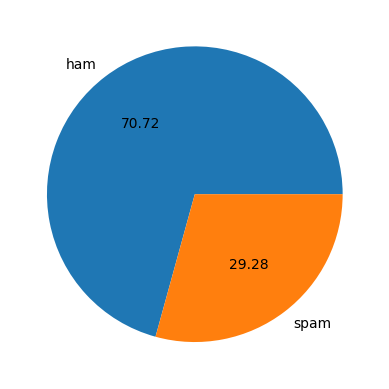

In [ ]:
print(mail_data['target'].value_counts())
plt.pie(mail_data['target'].value_counts(), labels=['ham','spam'],autopct="%0.2f")
plt.show()

In [ ]:
mail_data['num_characters'] = mail_data['text'].apply(len)
mail_data['num_words'] = mail_data['text'].apply(lambda x:len(nltk.word_tokenize(x)))
mail_data['num_sentences'] = mail_data['text'].apply(lambda x:len(nltk.sent_tokenize(x)))
mail_data.head()

,target,text,num_characters,num_words,num_sentences
0,0,Subject: enron methanol ; meter # : 988291\r\n...,327,68,3
1,0,"Subject: hpl nom for january 9 , 2001\r\n( see...",97,24,3
2,0,"Subject: neon retreat\r\nho ho ho , we ' re ar...",2524,551,24
3,1,"Subject: photoshop , windows , office . cheap ...",414,49,3
4,0,Subject: re : indian springs\r\nthis deal is t...,336,71,3


In [ ]:
# ham
mail_data[mail_data['target'] == 0][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,3531.000000,3531.000000,3531.000000
mean,994.939394,230.516001,11.662419
std,1402.785831,337.018933,25.330035
min,18.000000,3.000000,1.000000
25%,241.000000,53.000000,4.000000
50%,538.000000,128.000000,7.000000
75%,1253.500000,298.500000,13.500000
max,32258.000000,8863.000000,1204.000000


In [ ]:
#spam
mail_data[mail_data['target'] == 1][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,1462.000000,1462.000000,1462.000000
mean,1249.326265,241.315321,17.551984
std,1840.112883,349.439381,33.111447
min,11.000000,2.000000,1.000000
25%,304.250000,60.000000,4.000000
50%,589.000000,119.500000,9.000000
75%,1305.000000,252.750000,19.000000
max,22073.000000,3963.000000,693.000000


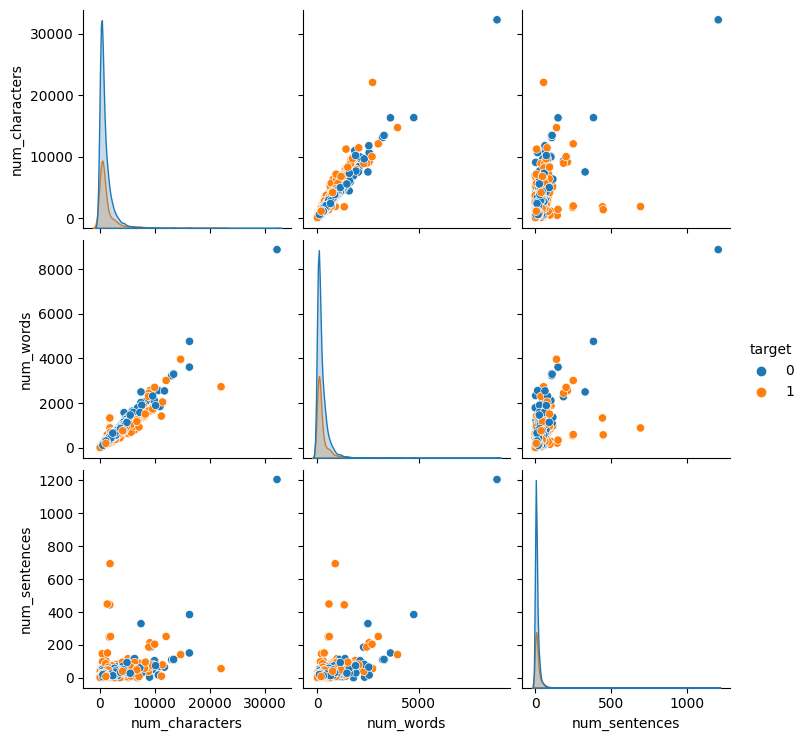

In [ ]:
sns.pairplot(mail_data,hue='target')

<ipython-input-12-9bbe2d18822c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data=mail_data.corr(),


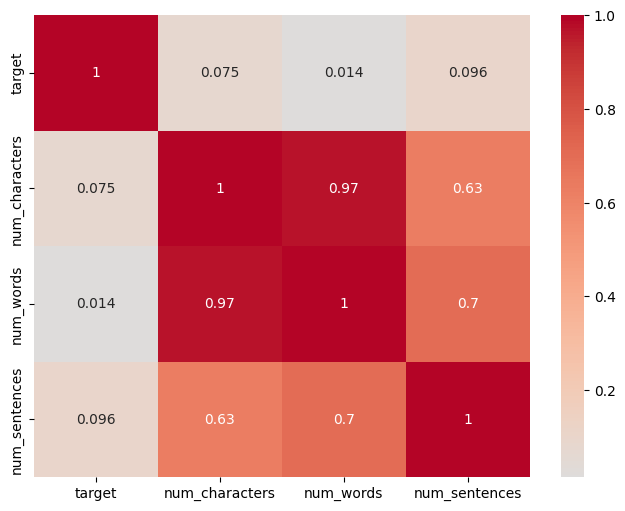

In [ ]:
sns.heatmap(data=mail_data.corr(),
            annot=True,
            cmap="coolwarm",
            center=0,
            ax=plt.subplots(figsize=(8,6))[1]);

### Data preprocessing


* Lower case
* Tokenization
* Removing special characters
* Removing stop words and punctuation
* Stemming

In [ ]:
def transform_text(text):
    # Convert the text to lowercase and tokenize it
    tokens = nltk.word_tokenize(text.lower())
    
    # Remove non-alphanumeric tokens (%^# )
    tokens = [t for t in tokens if t.isalnum()]
    
    # Remove stopwords and punctuation (I, how, u, are, is)
    stopwords_set = set(stopwords.words('english'))
    punctuation_set = set(string.punctuation)
    tokens = [t for t in tokens if t not in stopwords_set and t not in punctuation_set]
    
    # Stemming the remaining tokens using PorterStemmer (loving=love)
    ps = PorterStemmer()
    tokens = [ps.stem(t) for t in tokens]
    
    # Join the tokens back into a string and return it
    return " ".join(tokens)

In [ ]:
print(f"{mail_data['text'][10]}\n{transform_text(mail_data['text'][10])}")

Subject: vocable % rnd - word asceticism
vcsc - brand new stock for your attention
vocalscape inc - the stock symbol is : vcsc
vcsc will be our top stock pick for the month of april - stock expected to
bounce to 12 cents level
the stock hit its all time low and will bounce back
stock is going to explode in next 5 days - watch it soar
watch the stock go crazy this and next week .
breaking news - vocalscape inc . announces agreement to resell mix network
services
current price : $ 0 . 025
we expect projected speculative price in next 5 days : $ 0 . 12
we expect projected speculative price in next 15 days : $ 0 . 15
vocalscape networks inc . is building a company that ' s revolutionizing the
telecommunications industry with the most affordable phone systems , hardware ,
online software , and rates in canada and the us . vocalscape , a company with
global reach , is receiving international attention for the development of voice
over ip ( voip ) application solutions , including the award -

* #### Remove numbers 

In [ ]:
mail_data = mail_data.apply(lambda x: x.str.replace('\d+', '') if x.dtype == "object" else x)

<ipython-input-15-4c816e85d1f3>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  mail_data = mail_data.apply(lambda x: x.str.replace('\d+', '') if x.dtype == "object" else x)


In [ ]:
mail_data['transformed_text'] = mail_data['text'].apply(transform_text)
mail_data.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,Subject: enron methanol ; meter # : \r\nthis i...,327,68,3,subject enron methanol meter follow note gave ...
1,0,"Subject: hpl nom for january , \r\n( see atta...",97,24,3,subject hpl nom januari see attach file hplnol...
2,0,"Subject: neon retreat\r\nho ho ho , we ' re ar...",2524,551,24,subject neon retreat ho ho ho around wonder ti...
3,1,"Subject: photoshop , windows , office . cheap ...",414,49,3,subject photoshop window offic cheap main tren...
4,0,Subject: re : indian springs\r\nthis deal is t...,336,71,3,subject indian spring deal book teco pvr reven...


* #### Removal of Frequent words

In [ ]:
from collections import Counter
cnt = Counter()
for text in mail_data["transformed_text"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

[('ect', 13701),
 ('subject', 7832),
 ('hou', 7182),
 ('enron', 6442),
 ('com', 3702),
 ('deal', 3587),
 ('pleas', 3178),
 ('ga', 2961),
 ('meter', 2712),
 ('cc', 2336)]

In [ ]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    """custom function to remove the frequent word"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

mail_data["text_wo_stopfreq"] = mail_data["transformed_text"].apply(lambda text: remove_freqwords(text))
mail_data.head()

,target,text,num_characters,num_words,num_sentences,transformed_text,text_wo_stopfreq
0,0,Subject: enron methanol ; meter # : \r\nthis i...,327,68,3,subject enron methanol meter follow note gave ...,methanol follow note gave monday preliminari f...
1,0,"Subject: hpl nom for january , \r\n( see atta...",97,24,3,subject hpl nom januari see attach file hplnol...,hpl nom januari see attach file hplnol xl hpln...
2,0,"Subject: neon retreat\r\nho ho ho , we ' re ar...",2524,551,24,subject neon retreat ho ho ho around wonder ti...,neon retreat ho ho ho around wonder time year ...
3,1,"Subject: photoshop , windows , office . cheap ...",414,49,3,subject photoshop window offic cheap main tren...,photoshop window offic cheap main trend abas d...
4,0,Subject: re : indian springs\r\nthis deal is t...,336,71,3,subject indian spring deal book teco pvr reven...,indian spring book teco pvr revenu understand ...


* #### Removal of Rare words


In [ ]:
n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    """custom function to remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

mail_data["text_wo_stoprare"] = mail_data["text_wo_stopfreq"].apply(lambda text: remove_rarewords(text))
mail_data.head()

,target,text,num_characters,num_words,num_sentences,transformed_text,text_wo_stopfreq,text_wo_stoprare
0,0,Subject: enron methanol ; meter # : \r\nthis i...,327,68,3,subject enron methanol meter follow note gave ...,methanol follow note gave monday preliminari f...,methanol follow note gave monday preliminari f...
1,0,"Subject: hpl nom for january , \r\n( see atta...",97,24,3,subject hpl nom januari see attach file hplnol...,hpl nom januari see attach file hplnol xl hpln...,hpl nom januari see attach file hplnol xl hpln...
2,0,"Subject: neon retreat\r\nho ho ho , we ' re ar...",2524,551,24,subject neon retreat ho ho ho around wonder ti...,neon retreat ho ho ho around wonder time year ...,neon retreat ho ho ho around wonder time year ...
3,1,"Subject: photoshop , windows , office . cheap ...",414,49,3,subject photoshop window offic cheap main tren...,photoshop window offic cheap main trend abas d...,photoshop window offic cheap main trend abas d...
4,0,Subject: re : indian springs\r\nthis deal is t...,336,71,3,subject indian spring deal book teco pvr reven...,indian spring book teco pvr revenu understand ...,indian spring book teco pvr revenu understand ...


In [ ]:
mail_data.drop(columns=['transformed_text','text_wo_stopfreq'],inplace=True)
mail_data.rename(columns={'text_wo_stoprare':'clean_text'},inplace=True) 
mail_data.head()

,target,text,num_characters,num_words,num_sentences,clean_text
0,0,Subject: enron methanol ; meter # : \r\nthis i...,327,68,3,methanol follow note gave monday preliminari f...
1,0,"Subject: hpl nom for january , \r\n( see atta...",97,24,3,hpl nom januari see attach file hplnol xl hpln...
2,0,"Subject: neon retreat\r\nho ho ho , we ' re ar...",2524,551,24,neon retreat ho ho ho around wonder time year ...
3,1,"Subject: photoshop , windows , office . cheap ...",414,49,3,photoshop window offic cheap main trend abas d...
4,0,Subject: re : indian springs\r\nthis deal is t...,336,71,3,indian spring book teco pvr revenu understand ...


### Data Visualization 

In [ ]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

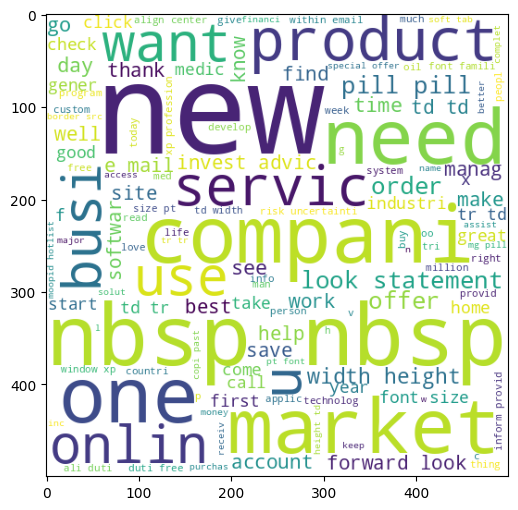

In [ ]:
spam_wc = wc.generate(mail_data[mail_data['target'] == 1]['clean_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(spam_wc)

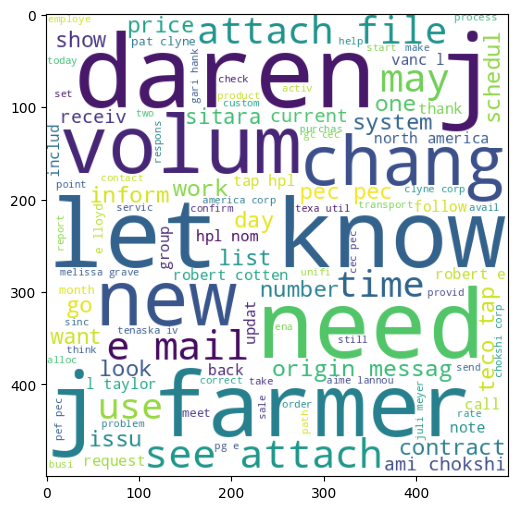

In [ ]:
ham_wc = wc.generate(mail_data[mail_data['target'] == 0]['clean_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(ham_wc)

In [ ]:
spam_corpus = []
for msg in mail_data[mail_data['target'] == 1]['clean_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

ham_corpus = []
for msg in mail_data[mail_data['target'] == 0]['clean_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)
  
print(len(spam_corpus), len(ham_corpus))

175407 267060


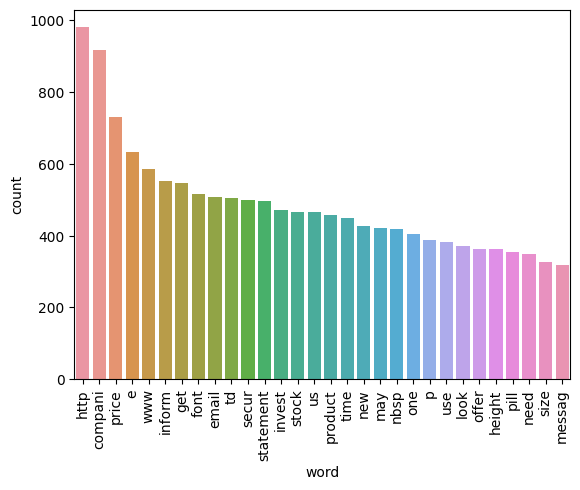

In [ ]:
from collections import Counter
word_freq = Counter(spam_corpus).most_common(30)
word_freq_mail_data = pd.DataFrame(word_freq, columns=['word', 'count'])
sns.barplot(data=word_freq_mail_data, x='word', y='count')
plt.xticks(rotation='vertical')
plt.show()

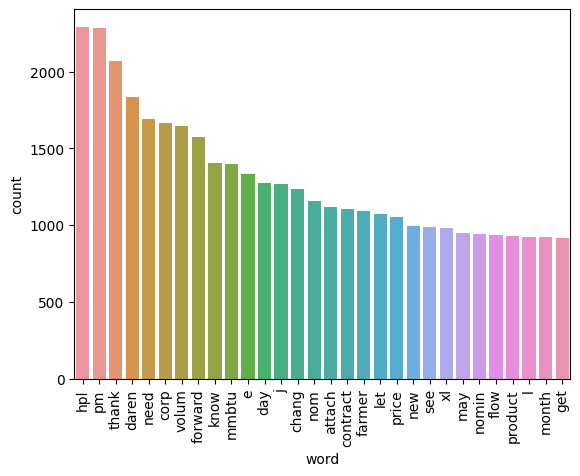

In [ ]:
word_freq = Counter(ham_corpus).most_common(30)
word_freq_mail_data = pd.DataFrame(word_freq, columns=['word', 'count'])
sns.barplot(data=word_freq_mail_data, x='word', y='count')
plt.xticks(rotation='vertical')
plt.show()

## **Model Building**

### RNN

In [ ]:
X=mail_data['clean_text']
y = mail_data['target'].values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

In [ ]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [ ]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 50)           50000     
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout_37 (Dropout)        (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257   

In [ ]:
model.fit(sequences_matrix,y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
25/25 [==============================] - 4s 33ms/step - loss: 0.4950 - accuracy: 0.7712 - val_loss: 0.2304 - val_accuracy: 0.9462
Epoch 2/10
25/25 [==============================] - 0s 13ms/step - loss: 0.2155 - accuracy: 0.9396 - val_loss: 0.1490 - val_accuracy: 0.9412
Epoch 3/10
25/25 [==============================] - 0s 10ms/step - loss: 0.0985 - accuracy: 0.9671 - val_loss: 0.1042 - val_accuracy: 0.9549
Epoch 4/10
25/25 [==============================] - 0s 10ms/step - loss: 0.0635 - accuracy: 0.9800 - val_loss: 0.0997 - val_accuracy: 0.9562
Epoch 5/10
25/25 [==============================] - 0s 10ms/step - loss: 0.0488 - accuracy: 0.9844 - val_loss: 0.1232 - val_accuracy: 0.9437


In [ ]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

In [ ]:
accr = model.evaluate(test_sequences_matrix,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

32/32 [==============================] - 0s 6ms/step - loss: 0.1202 - accuracy: 0.9580
Test set
  Loss: 0.120
  Accuracy: 0.958


## **Model Deployment**

### BERT

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

def bert_encode(data, maximum_length) :
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text, 
            add_special_tokens=True,
            max_length=maximum_length,
            pad_to_max_length=True,

            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
train_input_ids, train_attention_masks = bert_encode(X,60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

def create_model(bert_model):
    
    input_ids = tf.keras.Input(shape=(60,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(60,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
from transformers import TFBertModel
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
model = create_model(bert_model)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 60,                                          

In [ ]:
history = model.fit(
    [train_input_ids, train_attention_masks],
    y,
    validation_split=0.2, 
    epochs=3,
    batch_size=10
)

Epoch 1/3
400/400 [==============================] - 142s 238ms/step - loss: 0.6382 - accuracy: 0.7033 - val_loss: 0.6339 - val_accuracy: 0.6847
Epoch 2/3
400/400 [==============================] - 70s 175ms/step - loss: 0.6123 - accuracy: 0.7128 - val_loss: 0.6235 - val_accuracy: 0.6847
Epoch 3/3
400/400 [==============================] - 65s 163ms/step - loss: 0.6138 - accuracy: 0.7128 - val_loss: 0.6266 - val_accuracy: 0.6847


In [ ]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

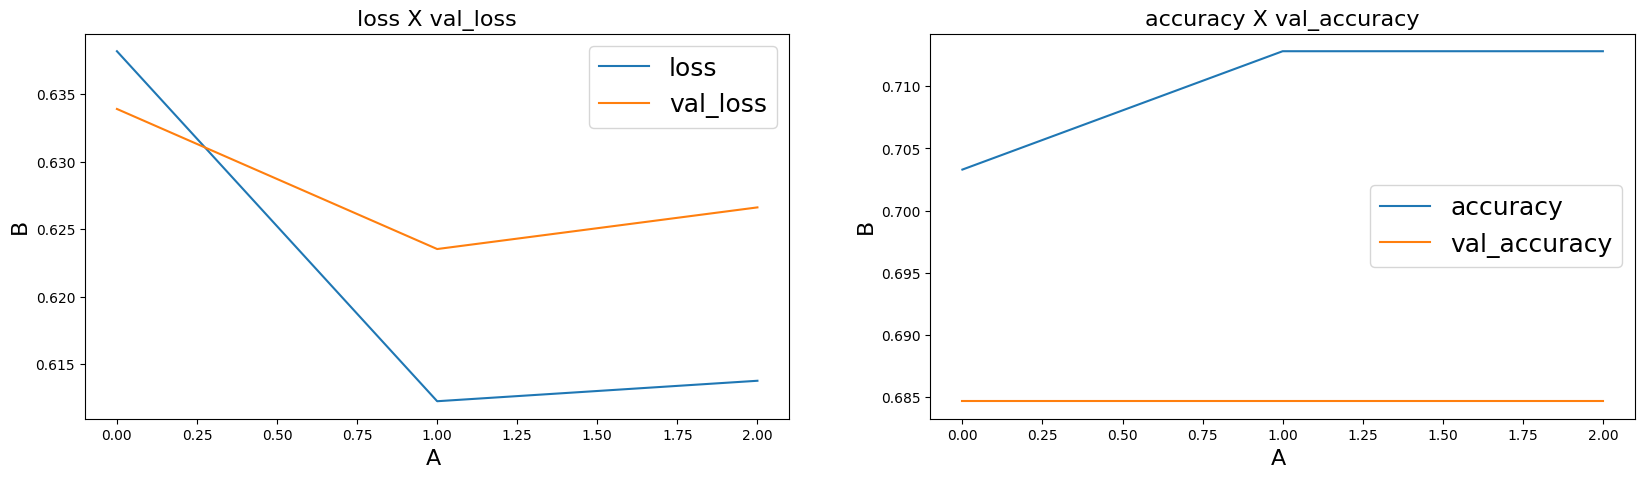

In [ ]:
plot_learning_curves(history, [['loss', 'val_loss'], ['accuracy', 'val_accuracy']])

## **Model Tuning**

In [ ]:
tfimail_data = TfidfVectorizer(max_features=3000)

In [ ]:
X = tfimail_data.fit_transform(mail_data['clean_text']).toarray()
y = mail_data['target'].values

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
model_params = {
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [10]
        }
    },
    'logistic_regression': {
        'model': LogisticRegression(solver='liblinear', multi_class='auto'),
        'params': {
            'logisticregression__C': [1, 5]
        }
    },
    'catboost': {
        'model': CatBoostClassifier(verbose=False),
        'params': {
            'catboostclassifier__iterations': [20],
            'catboostclassifier__learning_rate': [0.01],
            'catboostclassifier__depth': [4]
        }
    },
    'xgboost': {
        'model': XGBClassifier(),
        'params': {
            'xgbclassifier__n_estimators': [50],
            'xgbclassifier__max_depth': [4],
            'xgbclassifier__learning_rate': [0.01],
            'xgbclassifier__booster': ['gbtree']
        }
    },
    'gaussian_nb': {
        'model': GaussianNB(),
        'params': {}
    },
    'multinomial_nb': {
        'model': MultinomialNB(),
        'params': {}
    },
    'bernoulli_nb': {
        'model': BernoulliNB(),
        'params': {}
    },

    'stacking_model': {
        'model': StackingClassifier(
            estimators=[
                ('svc', SVC(kernel='linear', C=1, probability=True)),
                ('rf', RandomForestClassifier(n_estimators=10, random_state=42))
            ],
            final_estimator=LogisticRegression()
        ),
        'params': {
            'stackingclassifier__svc__kernel': ['rbf', 'linear'],
            'stackingclassifier__svc__C': [1, 10],
            'stackingclassifier__rf__n_estimators': [1, 5],
            'stackingclassifier__final_estimator__C': [1, 5]
        }
    }
}


In [ ]:
# Run a grid search to find the best hyperparameters for each model
best_scores = []
best_estimators = {}
kfold = KFold(n_splits=5, shuffle=True, random_state=42)


for algo, mp in model_params.items():
    pipe = make_pipeline(MinMaxScaler(), mp['model'])
    clf =  RandomizedSearchCV(pipe, mp['params'], cv=kfold, return_train_score=False)
    clf.fit(X_train, y_train)
    best_scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
mail_data = pd.DataFrame(best_scores,columns=['model','best_score','best_params'])
mail_data

c:\Users\Himasha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\Himasha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\Himasha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\Himasha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Runnin

,model,best_score,best_params
0,random_forest,0.950425,{'randomforestclassifier__n_estimators': 10}
1,logistic_regression,0.977468,{'logisticregression__C': 1}
2,catboost,0.793442,"{'catboostclassifier__learning_rate': 0.01, 'c..."
3,xgboost,0.826496,"{'xgbclassifier__n_estimators': 50, 'xgbclassi..."
4,gaussian_nb,0.955685,{}
5,multinomial_nb,0.946169,{}
6,bernoulli_nb,0.901604,{}
7,stacking_model,0.976966,"{'stackingclassifier__svc__kernel': 'rbf', 'st..."


In [ ]:
for algo, estimator in best_estimators.items():
    print(f"Evaluating {algo}...")
    score = estimator.score(X_test, y_test)
    print(f"Test score: {score}\n")

Evaluating random_forest...
Test score: 0.9529529529529529

Evaluating logistic_regression...
Test score: 0.968968968968969

Evaluating catboost...
Test score: 0.8418418418418419

Evaluating xgboost...
Test score: 0.8508508508508509

Evaluating gaussian_nb...
Test score: 0.955955955955956

Evaluating multinomial_nb...
Test score: 0.9479479479479479

Evaluating bernoulli_nb...
Test score: 0.9179179179179179

Evaluating stacking_model...
Test score: 0.9679679679679679



In [ ]:
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [ ]:
classifier = LogisticRegression()

In [ ]:
classifier.fit(X_train,y_train)

LogisticRegression()

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
accuracy_score(y_pred, y_test)

0.973973973973974

In [ ]:
class_names = mail_data.target

In [ ]:
print('Precision: %.3f' % precision_score(y_test, y_pred))

Precision: 0.958


In [ ]:
print('Recall: %.3f' % recall_score(y_test, y_pred))

Recall: 0.944


In [ ]:
print('F1 Score: %.3f' % f1_score(y_test, y_pred))

F1 Score: 0.951


# _User Interface_

Storing model in pickle

In [ ]:
word_dict = Counter(word)

In [ ]:
word_dict_pickle = open("word_pickle.pkl", "ab")
pickle.dump(word_dict, word_dict_pickle)
word_dict_pickle.close()


In [ ]:
pickle.dump(classifier,open('spam.pkl', 'wb'))


In [ ]:
clf = pickle.load(open('spam.pkl', 'rb'))

In [ ]:
#Ham mail prediction

In [ ]:
new_gmail1 = """hi the team saw your presentation on marketing and they really happy. lets have a meeting tommorrow"""

In [ ]:
sample1 = []
for i in word_dict:
    sample1.append(new_gmail1.split(" ").count(i[0]))

sample1 = np.array(sample1)

In [ ]:
sample1.shape

(3,)

In [ ]:
classifier.predict(sample1.reshape(1,3000)) 

In [ ]:
new_gmail2 = """hi you won 100000000000"""

In [ ]:
sample2 = []
for i in word_dict:
    sample2.append(new_gmail2.split(" ").count(i[0]))

sample2 = np.array(sample2)

In [ ]:
classifier.predict(sample2.reshape(1,3000))